In [1]:
# === Dipendenze ===
import warnings
warnings.filterwarnings("ignore")

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import osmnx as ox
import pandas as pd

try:
    import contextily as ctx
    HAS_CTX = True
except Exception:
    HAS_CTX = False

ox.settings.use_cache = True
ox.settings.log_console = False
ox.settings.timeout = 180

# === Parametri ===
PARAMS = {
    "center_latlon": (41.940583, 12.418912),  # Santa Maria della Pietà
    "dist_m": 5000,                           # raggio in metri
    "crs_metric": "EPSG:32633",               # UTM 33N
    "use_basemap": True,                      # usa basemap CartoDB se contextily disponibile
}

In [2]:


# === AOI: buffer metrico attorno al punto ===
lat, lon = PARAMS["center_latlon"]
gdf_pt = gpd.GeoDataFrame(geometry=[Point(lon, lat)], crs=4326)
aoi_m = gdf_pt.to_crs(PARAMS["crs_metric"]).buffer(PARAMS["dist_m"])
aoi = aoi_m.to_crs(4326).iloc[0]                   # polygon in WGS84 per query
aoi_gdf = gpd.GeoDataFrame(geometry=[aoi], crs=4326)

# === EDIFICI (solo poligoni) ===
building_tags = {"building": True}

if hasattr(ox, "features_from_polygon"):
    buildings = ox.features_from_polygon(aoi, tags=building_tags)
else:
    buildings = ox.geometries_from_polygon(aoi, tags=building_tags)

# Filtro e proiezione
buildings = buildings[buildings.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()
buildings = gpd.clip(buildings, aoi_gdf)
buildings3857 = buildings.to_crs(3857)


# === Tag “verde” da OSM ===
tags = {
    "leisure": [
        "park", "garden", "recreation_ground", "nature_reserve",
        "golf_course", "dog_park", "playground", "pitch"    ],
    "landuse": [
        "grass", "forest", "recreation_ground", "meadow",
        "orchard", "vineyard", "cemetery", "farmland", "flowerbed",
        "greenfield", "allotments", "reservoir", "basin",
        "greenhouse_horticulture", "farmyard"  # NEW
    ],
    "natural": [
        "wood", "grassland", "heath", "scrub", "wetland", "water",
        "tree_row", "shrub"  # NEW
    ],
    "man_made": [
        "flowerbed", "planter"  # NEW (alcuni planters sono grandi, e possono contenere verde urbano)
    ],
    "barrier": [
        "hedge"  # siepi
    ],
    "surface": [
        "grass", "sand", "tartan", "ground", "dirt"  # NEW – superfici verdi o da parco giochi
    ]
}

# === Download geometrie OSM (compat v1/v2) ===
if hasattr(ox, "features_from_polygon"):          # OSMnx v2.x
    gdf = ox.features_from_polygon(aoi, tags=tags)
else:                                             # OSMnx v1.x
    gdf = ox.geometries_from_polygon(aoi, tags=tags)

# Tieni solo poligoni
gdf = gdf[gdf.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()
# Clip all'AOI
gdf = gpd.clip(gdf, aoi_gdf)

# Categoria (macro-chiave)
def pick_cat(row):
    for c in ["leisure", "landuse", "natural"]:
        v = row.get(c)
        if isinstance(v, str) and v:
            return f"{c}:{v}"
    return "other"

gdf["category"] = gdf.apply(pick_cat, axis=1)

# === Plot (Web Mercator per basemap) ===
gdf3857 = gdf.to_crs(3857)
aoi3857 = aoi_gdf.to_crs(3857)

# --- ACQUE: poligoni e linee (OSM) ---
water_tags_poly = {
    "natural": ["water", "wetland"],
    "landuse": ["reservoir", "basin"],
    "water": ["lake", "pond", "reservoir", "river", "canal"]
}
water_tags_line = {
    "waterway": ["river", "stream", "canal", "ditch", "drain"]
}

# Poligoni d'acqua
if hasattr(ox, "features_from_polygon"):
    water_poly = ox.features_from_polygon(aoi, tags=water_tags_poly)
else:
    water_poly = ox.geometries_from_polygon(aoi, tags=water_tags_poly)

# Tieni solo poligoni/multipoligoni e clippa
water_poly = water_poly[water_poly.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()
water_poly = gpd.clip(water_poly, aoi_gdf)
water_poly3857 = water_poly.to_crs(3857)

# Linee d'acqua
if hasattr(ox, "features_from_polygon"):
    water_line = ox.features_from_polygon(aoi, tags=water_tags_line)
else:
    water_line = ox.geometries_from_polygon(aoi, tags=water_tags_line)

# Tieni solo LineString/MultiLineString e clippa
water_line = water_line[water_line.geometry.type.isin(["LineString", "MultiLineString"])].copy()
water_line = gpd.clip(water_line, aoi_gdf)
water_line3857 = water_line.to_crs(3857)

# --- FILTRO: tieni solo corsi d'acqua visibili (fiumi e canali, non sotterranei) ---
if "waterway" in water_line.columns:
    def is_visible_water(row):
        tipo = str(row.get("waterway", ""))
        tunnel = str(row.get("tunnel", ""))
        layer = str(row.get("layer", ""))
        return (tipo in ["river", "canal"]) and (tunnel != "yes") and (layer not in ["-1", "-2"])
    
    water_line_visible = water_line[water_line.apply(is_visible_water, axis=1)].copy()
    water_line3857 = water_line_visible.to_crs(3857)
else:
    # fallback: se manca la colonna, lascio tutto
    water_line_visible = water_line


# Stili acqua
WATER_FILL = "#4aa3df"   # azzurro poligoni
WATER_EDGE = "#2c7fb8"   # bordo poligoni
WATER_LINE = "#2c7fb8"   # linee fiumi/rogge

# --- Opzioni layer leggeri ---
SHOW_ROADS = True
SHOW_LANDUSE_OUTLINES = True      # contorni sottili e tratteggiati
SHOW_LANDUSE_CENTROIDS = False    # alternative: puntini ai centroidi

# --- STRADE (rete "drive" nell'AOI) ---
edges_major3857 = gpd.GeoDataFrame(geometry=[], crs=3857)
edges_minor3857 = gpd.GeoDataFrame(geometry=[], crs=3857)

try:
    G = ox.graph_from_polygon(aoi, network_type="drive", simplify=True)
    edges = ox.graph_to_gdfs(G, nodes=False, edges=True)

    # Classifica le strade
    MAJOR_BASE = {"motorway", "trunk", "primary", "secondary", "tertiary"}

    def normalize_highway(hw):
        if hw is None or (isinstance(hw, float) and pd.isna(hw)):
            return []
        if isinstance(hw, (list, set, tuple)):
            vals = list(hw)
        else:
            vals = [hw]
        cleaned = []
        for v in vals:
            s = str(v).lower().strip()
            if s.endswith("_link"):
                s = s[:-5]
            cleaned.append(s)
        return cleaned

    def classify_road(hw):
        base_vals = normalize_highway(hw)
        return "major" if any(b in MAJOR_BASE for b in base_vals) else "minor"

    # Applica classificazione e conversione CRS
    edges["road_class"] = edges["highway"].apply(classify_road)
    edges3857 = edges.to_crs(3857)
    edges_major3857 = edges3857[edges3857["road_class"] == "major"].copy()
    edges_minor3857 = edges3857[edges3857["road_class"] == "minor"].copy()

except Exception as e:
    print("Errore durante il caricamento delle strade:", e)

# Rendi disponibili per il plot
globals()["edges_major3857"] = edges_major3857
globals()["edges_minor3857"] = edges_minor3857

# --- LANDUSE: contorni/centroidi leggeri ---
landuse_gdf = gdf.loc[gdf["landuse"].notna()].copy()
landuse3857 = landuse_gdf.to_crs(3857)
landuse_centroids3857 = landuse3857.copy()
landuse_centroids3857["geometry"] = landuse_centroids3857.geometry.centroid


palette = {
    "leisure":  "#6FD08C",  # verde chiaro
    "landuse":  "#A3D977",  # verde giallognolo
    "natural":  "#4DAA57",  # verde scuro
    "other":    "#BFDDBF",  # grigio-verde chiaro
}

def top_key(cat): return cat.split(":")[0] if isinstance(cat, str) and ":" in cat else "other"
colors = gdf3857["category"].apply(lambda c: palette.get(top_key(c), palette["other"]))



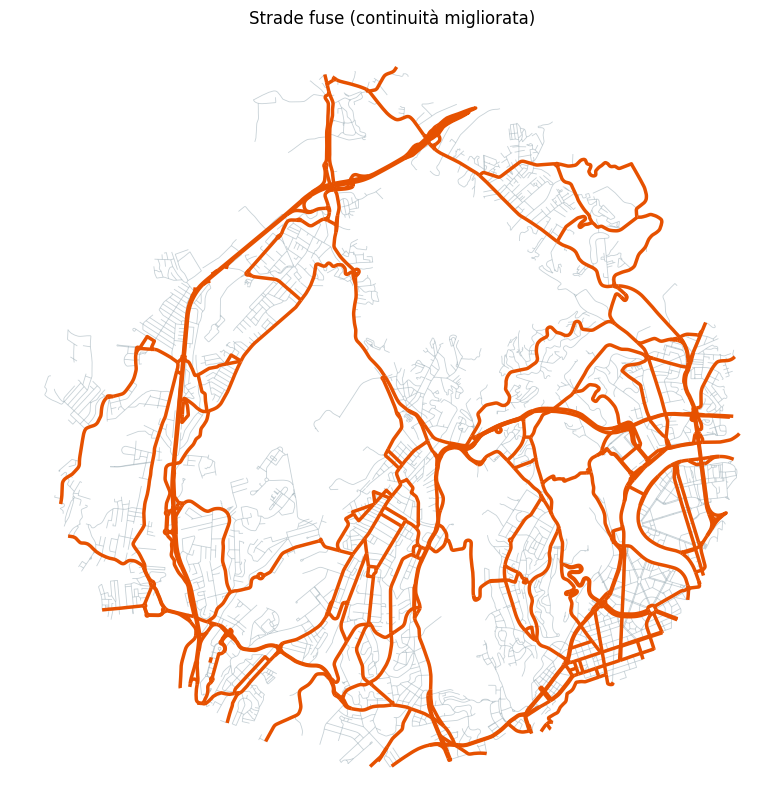

In [ ]:
from shapely.ops import linemerge, unary_union

def unisci_segmenti(gdf):
    if gdf.empty:
        return gpd.GeoDataFrame(geometry=[], crs=gdf.crs)

    # Unisci tutte le geometrie in un'unica MultiLineString e poi fondi le connessioni
    merged = linemerge(unary_union(gdf.geometry))
    
    # Se il risultato è una singola LineString, lo mettiamo in una lista
    if merged.geom_type == "LineString":
        geometries = [merged]
    else:
        geometries = list(merged.geoms)

    return gpd.GeoDataFrame(geometry=geometries, crs=gdf.crs)

# Crea versioni "fuse" per il test o il plot
edges_major_fused = unisci_segmenti(edges_major3857)
edges_minor_fused = unisci_segmenti(edges_minor3857)

# fig, ax = plt.subplots(figsize=(10, 10))
# edges_minor_fused.plot(ax=ax, color="#90a4ae", linewidth=0.6, alpha=0.5)
# edges_major_fused.plot(ax=ax, color="#e65100", linewidth=2.5)
# plt.title("Strade fuse (continuità migliorata)")
# plt.axis("off")
# plt.show()



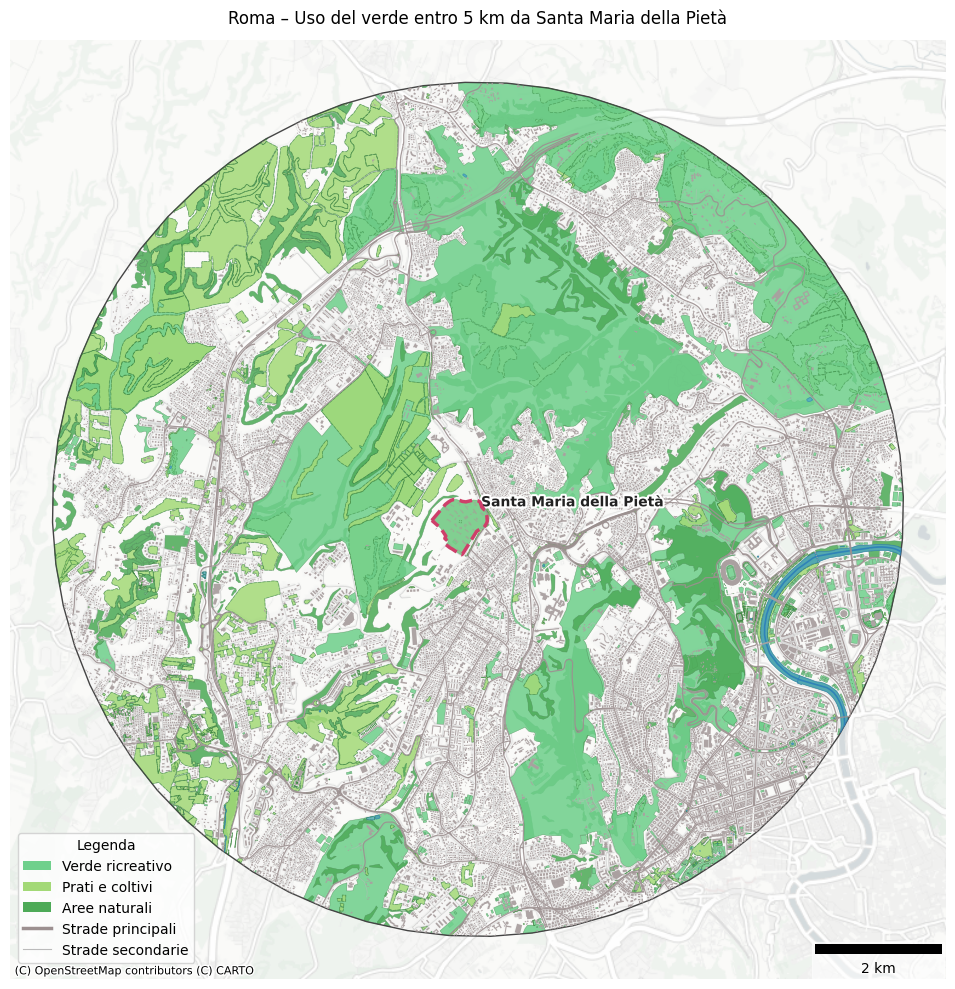

Creato file: mappa_verde_smdp.png


In [4]:
import pandas as pd
import matplotlib.patheffects as pe
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(10,10))

# --- AOI e verde ---
aoi3857.boundary.plot(ax=ax, color="#444444", linewidth=1.0)
gdf3857.plot(ax=ax, color=colors, edgecolor="#4F8F59", linewidth=0.3, alpha=0.85)

# --- Basemap (PRIMA di tutto, sotto a tutto) ---
if PARAMS["use_basemap"] and HAS_CTX:
    try:
        ctx.add_basemap(
            ax, crs=gdf3857.crs,
            source=ctx.providers.CartoDB.PositronNoLabels,
            zorder=-10
        )
    except Exception:
        pass

# --- ACQUE ---
if not water_poly3857.empty:
    water_poly3857.plot(
        ax=ax, facecolor=WATER_FILL, edgecolor=WATER_EDGE,
        linewidth=0.6, alpha=0.6, zorder=6
    )
if not water_line3857.empty:
    water_line3857.plot(
        ax=ax, color=WATER_LINE, linewidth=1.2, alpha=0.9, zorder=7
    )

# --- STRADE FUSE: principali e minori ---
if SHOW_ROADS:
    COLOR_MAJOR = "#9C9090"
    COLOR_MINOR = "#bbbbbb"
    if not edges_minor_fused.empty:
        edges_minor_fused.plot(
            ax=ax, linewidth=0.6, alpha=0.5,
            color=COLOR_MINOR, zorder=30
        )
    if not edges_major_fused.empty:
        edges_major_fused.plot(
            ax=ax, linewidth=0.9, alpha=0.9,
            color=COLOR_MAJOR, zorder=31
        )

# --- LANDUSE ---
if SHOW_LANDUSE_OUTLINES and not landuse3857.empty:
    landuse3857.boundary.plot(
        ax=ax, linewidth=0.6, linestyle="--", alpha=0.4, color="#2e7d32", zorder=8
    )
if SHOW_LANDUSE_CENTROIDS and not landuse_centroids3857.empty:
    ax.scatter(
        landuse_centroids3857.geometry.x, landuse_centroids3857.geometry.y,
        s=8, marker='o', color="#2e7d32", alpha=0.6, zorder=6
    )

# --- EDIFICI: disegnati sopra ---
if not buildings3857.empty:
    buildings3857.plot(
        ax=ax,
        color="#aaa0a0",  # o "#e6e6e6"
        edgecolor=None,
        linewidth=0.0,
        alpha=0.95,
        zorder=50
    )

# --- Legenda in italiano, spostata in alto ---
etichetta_italiana = {
    "leisure":  "Verde ricreativo",
    "landuse":  "Prati e coltivi",
    "natural":  "Aree naturali"
}

handles = [Patch(facecolor=palette[k], edgecolor="none", label=etichetta_italiana[k])
           for k in ["leisure", "landuse", "natural"]]

road_legend = [
    Line2D([0], [0], color=COLOR_MAJOR, lw=2.5, label="Strade principali"),
    Line2D([0], [0], color=COLOR_MINOR, lw=0.8, label="Strade secondarie")
]
handles += road_legend
ax.legend(
    handles=handles,
    loc="lower left",
    bbox_to_anchor=(0.001, 0.01),
    title="Legenda"
)

# --- Titolo, scalebar ---
ax.set_axis_off()
ax.set_title("Roma – Uso del verde entro 5 km da Santa Maria della Pietà", pad=12)

import matplotlib_scalebar.scalebar as sb
scalebar = sb.ScaleBar(1, units="m", dimension="si-length", location="lower right", box_alpha=0.6)
ax.add_artist(scalebar)

# --- Marker Santa Maria della Pietà (ULTIMO, sopra tutto) ---
# === Trova la geometria verde che contiene il punto ===
# punto: Santa Maria della Pietà
point_3857 = gpd.GeoDataFrame(geometry=[Point(lon, lat)], crs=4326).to_crs(3857)
p = point_3857.geometry.iloc[0]

# (1) filtro "verdi"
gdf_verde = gdf3857[gdf3857["category"].str.startswith(("leisure:", "landuse:", "natural:"))].copy()

# (2) trova geometrie che contengono/intersecano il punto
gdf_verde_hit = gdf_verde[gdf_verde.intersects(p)].copy()


# === Evidenzia la geometria del Comprensorio ===
if not gdf_verde_hit.empty:
    gdf_verde_hit.boundary.plot(
        ax=ax,
        color="#CE3F6A",
        linewidth=2.5,
        linestyle="--",
        zorder=150
    )
    gdf_verde_hit.plot(
        ax=ax,
        color="#81C784",
        alpha=0.4,
        edgecolor=None,
        zorder=140
    )
    
# ax.scatter(
#     point_3857.geometry.x,
#     point_3857.geometry.y,
#     s=120, marker='*', color='#d62828', edgecolor='white', linewidth=1.5, zorder=100
# )
for x, y in zip(point_3857.geometry.x, point_3857.geometry.y):
    ax.text(
        x + 50, y + 50, "Santa Maria della Pietà",
        fontsize=10, fontweight='bold', color='#222222',
        path_effects=[pe.withStroke(linewidth=3, foreground="white")],
        zorder=101
    )

plt.tight_layout()
plt.savefig("mappa_verde_smdp.png", dpi=200, bbox_inches="tight")
plt.show()

print("Creato file: mappa_verde_smdp.png")
